In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import norm,skew
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

#导入数据
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
print(train.columns)   #读取列表中所有列的列名

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

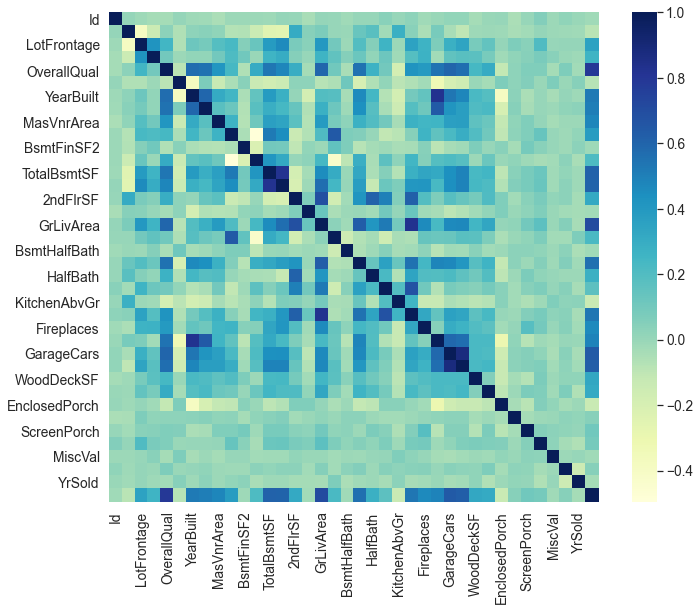

In [18]:
#绘制热力图
corrmat=train.corr()
f,ax=plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,square=True,cmap='YlGnBu')
plt.show()

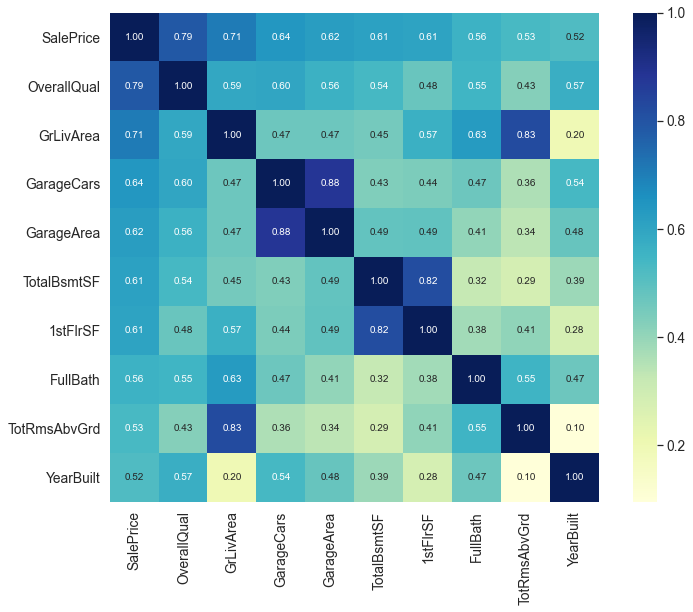

In [19]:
#查看影响最终价格的相关度较高的几个特征
k = 10
plt.figure(figsize=(12,9))
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap='YlGnBu')
plt.show()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


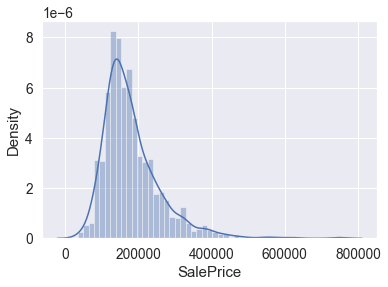

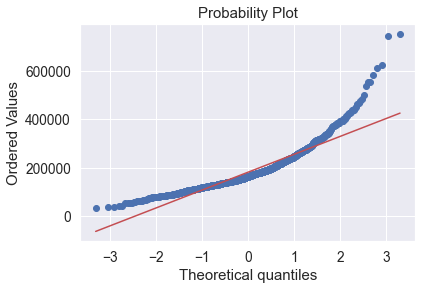

In [20]:
#查看因变量SalePrice
print(train['SalePrice'].describe())   #分析目标变量
sns.distplot((train['SalePrice'])) #查看是否满足正态分布
plt.show()
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

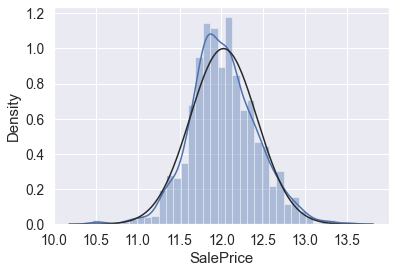


 mu=180921.20 and sigma=79415.29



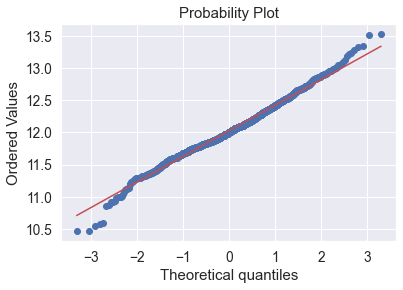

In [21]:
#转换为正态分布

train['SalePrice'] = np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'], fit=norm)
plt.show()

(mu, sigma) = norm.fit(df_train['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f}\n'.format(mu, sigma))

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [51]:
#连接训练集与测试集
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('all_data size is :{}'.format(all_data.shape))

all_data size is :(2919, 80)


In [24]:
#打印缺失值
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
print(missing_data)

              Missing Ratio
PoolQC            99.657417
MiscFeature       96.402878
Alley             93.216855
Fence             80.438506
FireplaceQu       48.646797
LotFrontage       16.649538
GarageFinish       5.447071
GarageQual         5.447071
GarageCond         5.447071
GarageYrBlt        5.447071
GarageType         5.378554
BsmtExposure       2.809181
BsmtCond           2.809181
BsmtQual           2.774923
BsmtFinType2       2.740665
BsmtFinType1       2.706406
MasVnrType         0.822199
MasVnrArea         0.787941
MSZoning           0.137033
BsmtFullBath       0.068517
BsmtHalfBath       0.068517
Functional         0.068517
Utilities          0.068517
GarageArea         0.034258
GarageCars         0.034258
Electrical         0.034258
KitchenQual        0.034258
TotalBsmtSF        0.034258
BsmtUnfSF          0.034258
BsmtFinSF2         0.034258


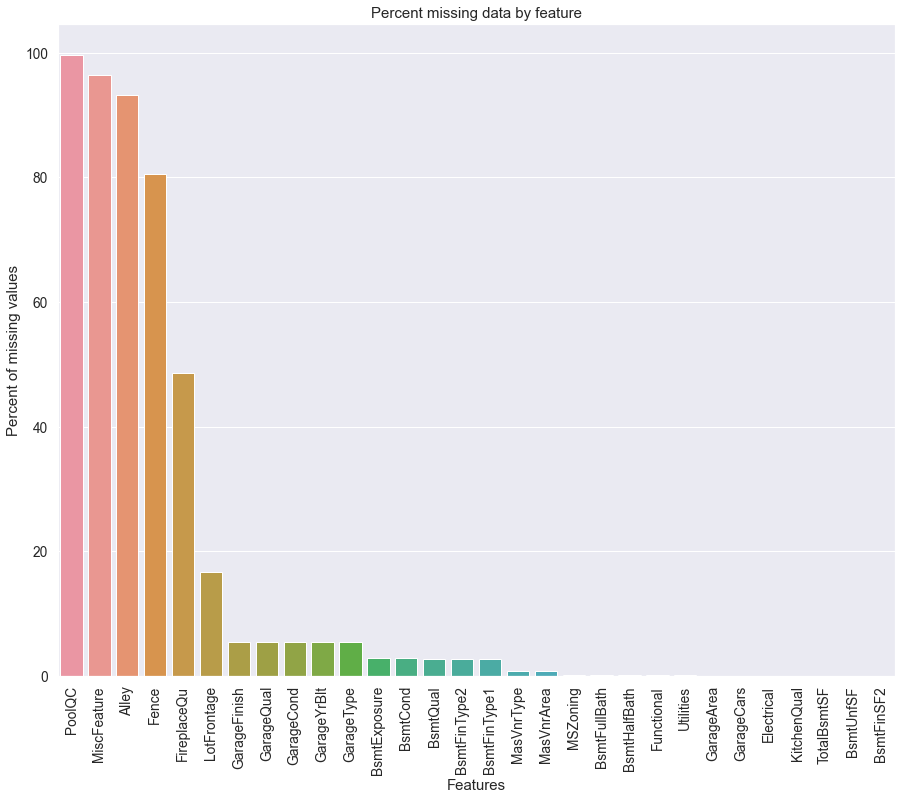

In [25]:
#转换为柱状图
f, ax=plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na. index,y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

In [28]:
#对缺失值补充处理

#查看游泳池数据，并填充
all_data['PoolQC']=all_data['PoolQC'].fillna('None')

all_data['MiscFeature']=all_data['MiscFeature'].fillna('None')

#通道的入口
all_data['Alley']=all_data['Alley'].fillna('None')

#栅栏
all_data['Fence']=all_data['Fence'].fillna('None')

#壁炉
all_data['FireplaceQu']=all_data['FireplaceQu'].fillna('None')

#离街道的距离（用临近值代替）
all_data['LotFrontage']=all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

#车库的一系列特征
for col in ('GarageFinish','GarageQual','GarageCond','GarageType'):
    all_data[col]=all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

#地下室的一系列特征
for col in ('BsmtFullBath','BsmtUnfSF','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtHalfBath'):
    all_data[col]=all_data[col].fillna(0)
for col in ('BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1'):
    all_data[col]=all_data[col].fillna('None')

#砌体
all_data['MasVnrType']=all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea']=all_data['MasVnrArea'].fillna(0)
all_data['MSZoning'].mode()

#一般分区分类
all_data['MSZoning']=all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

#家庭功能评定  对于Functional，数据描述里说明，其NA值代表Typ
all_data['Functional']=all_data['Functional'].fillna('Typ')

#电力系统
all_data['Electrical']=all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

#厨房品质
all_data['KitchenQual']=all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

#外部
all_data['Exterior1st']=all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd']=all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

#销售类型
all_data['SaleType']=all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

#建筑类型
all_data['MSSubClass']=all_data['MSSubClass'].fillna('None')

all_data=all_data.drop(['Utilities'],axis=1)

In [29]:
#查看缺失值是否处理完毕
all_data_na=(all_data.isnull().sum()/len(all_data))*100
all_data_na=all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
missing_data=pd.DataFrame({'Missing Ratio':all_data_na})
print(missing_data)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [31]:
#对某些类别特征进行类型转换
all_data['MSSubClass']=all_data['MSSubClass'].apply(str)
all_data['OverallCond']=all_data['OverallCond'].astype(str)
all_data['YrSold']=all_data['YrSold'].astype(str)
all_data['MoSold']=all_data['MoSold'].astype(str)

cols=('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',\
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',\
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',\
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',\
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

In [33]:
#一般房价与房子整体的面积有关，所以这里多做一个特征，将几个面积整合在一起
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
umeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[umeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})

In [34]:
#使用pandas的dummy方法来进行数据独热编码，并形成最终的训练和测试数据集:
skewness = skewness[abs(skewness) > 0.75]
print('there are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))
from scipy.special import boxcox1p
skewed_feats_index = skewness.index
lam = 0.15
for feat in skewed_feats_index:
    all_data[feat] = boxcox1p(all_data[feat], lam)

# getting dummy categorical features onehot？？？
all_data = pd.get_dummies(all_data)
print(all_data.shape)
# getting the new train and test sets
train = all_data[:ntrain]
test = all_data[ntrain:]

there are 60 skewed numerical features to Box Cox transform
(2919, 222)


In [35]:
#定义交叉验证函数
n_folds=5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

In [36]:
#定义Lasso模型
lasso=make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=1))

In [37]:
#定义ElasticNet模型
ENet=make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=3))

In [38]:
#定义KernelRidge带有核函数的岭回归模型
KRR=KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [39]:
#定义GradientBoostingRegressor模型
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)

In [40]:
#定义XGboost模型
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, random_state=7, nthread=-1)

In [41]:
#定义lightgbm模型
lgb_model =lgb.LGBMRegressor(objective='regression',num_leaves=1000,learning_rate=0.05,n_estimators=350,reg_alpha=0.9)

In [42]:
#输出每个模型的得分
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(xgb_model)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(lgb_model)
print("lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1240 (0.0165)

ElasticNet score: 0.1241 (0.0165)

Kernel Ridge score: 0.1273 (0.0113)

Gradient Boosting score: 0.1248 (0.0122)

[01:51:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

In [45]:
#模型整合
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        # train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    # we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

averaged_models = AveragingModels(models=(ENet, GBoost, KRR, lasso))
score_all = rmsle_cv(averaged_models)
print('Averaged base models score: {:.4f} ({:.4f})\n'.format(score_all.mean(), score_all.std()))

Averaged base models score: 0.1198 (0.0144)



In [47]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model = lasso)
score_all_stacked = rmsle_cv(stacked_averaged_models)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_test_pred = np.expm1(stacked_averaged_models.predict(test.values))
xgb_model.fit(train, y_train)
xgb_train_pred = xgb_model.predict(train)
xgb_test_pred = np.expm1(xgb_model.predict(test))
lgb_model.fit(train, y_train)
lgb_train_pred = lgb_model.predict(train)
lgb_test_pred = np.expm1(lgb_model.predict(test.values))
print('RMSLE score on train data all models:')
print(rmsle(y_train, stacked_train_pred * 0.6 + xgb_train_pred * 0.20 +lgb_train_pred * 0.20 ))
ensemble_result = stacked_test_pred * 0.60 + xgb_test_pred * 0.20 + lgb_test_pred *0.20

[02:13:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSLE score on train data all models:
0.07474665374689242


In [52]:
#输出结果
test_ID = test['Id']
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = ensemble_result
submission.to_csv('newstart1.csv', index=False)